## Задание 1

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import os
import sys


os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession.builder.getOrCreate()

file = r"C:\Users\kuzik\Downloads\bestsellers with categories.csv"
pandas_df = pd.read_csv(file)

df = spark.createDataFrame(pandas_df)
# print('\n\n')
print(df)
# print(type(df))
# print('\n\n')
# df.show()


DataFrame[Name: string, Author: string, User Rating: double, Reviews: bigint, Price: bigint, Year: bigint, Genre: string]


In [3]:
# Используя только RDD вычислить среднюю цену всех книг, у которых рейтинг выше 4.7
df.filter(df['User Rating'] >= 4.7).agg({"Price": "avg"}).show()

+------------------+
|        avg(Price)|
+------------------+
|11.560975609756097|
+------------------+



(array([287., 131.,  87.,  25.,   4.,   8.,   5.,   0.,   0.,   3.]),
 array([3.70000e+01, 8.81740e+03, 1.75978e+04, 2.63782e+04, 3.51586e+04,
        4.39390e+04, 5.27194e+04, 6.14998e+04, 7.02802e+04, 7.90606e+04,
        8.78410e+04]),
 <BarContainer object of 10 artists>)

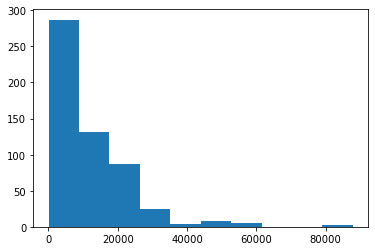

In [4]:
# Построить гистограмму распределения рецензий (столбец Reviews)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(df.toPandas()['Reviews'])

In [5]:
df_corr = df.select("User Rating", "Reviews", "Price")
df_corr

DataFrame[User Rating: double, Reviews: bigint, Price: bigint]

In [6]:
df

DataFrame[Name: string, Author: string, User Rating: double, Reviews: bigint, Price: bigint, Year: bigint, Genre: string]

In [7]:
# Построить матрицу корреляции для столбцов "User Rating", "Reviews" и "Price".
# df_corr.corr("User Rating", "Price")
# df_corr.corr("Reviews", "Price")
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_corr.columns, outputCol=vector_col)
df_vector = assembler.transform(df_corr).select(vector_col)

# get correlation matrix
# matrix = Correlation.corr(df_vector, vector_col)

<AxesSubplot:>

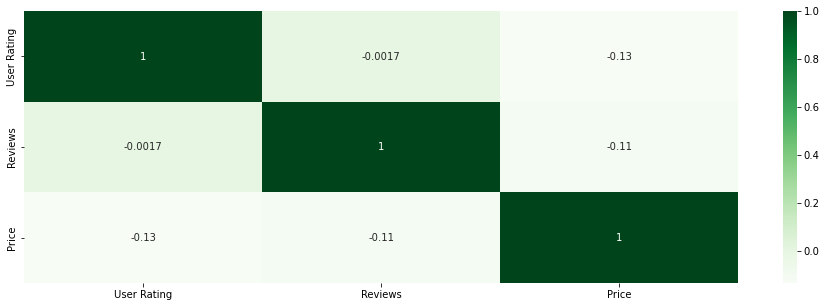

In [8]:
import seaborn as sns

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df_corr.columns, index=df_corr.columns) 
plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

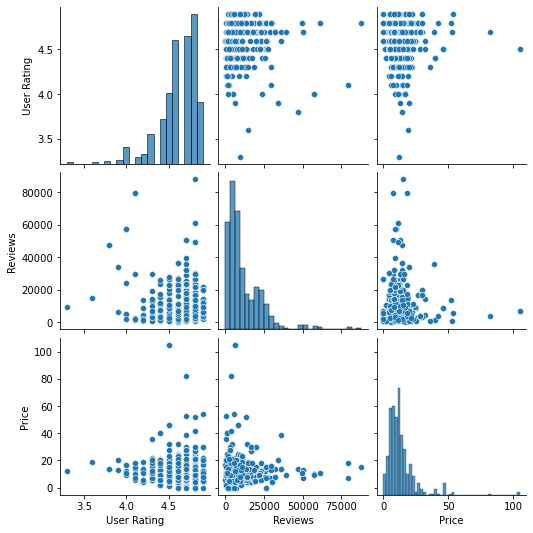

In [9]:
# Используя библиотеку seaborn построить парные графики (pairplots) столбцов "User Rating", "Reviews" и "Price"
sns.pairplot(data=df_corr.toPandas())

## Задание 2
##### При выполнении этого задания разрешается использовать только Spark SQL. 
##### Для датасета из предыдущего задания выполните следующее:

In [10]:
# Найдите автора с самым высоким рейтингом.
df.groupBy("Author").agg({"User Rating": "avg"}).sort("avg(User Rating)", ascending=False).show(1)


+------------------+----------------+
|            Author|avg(User Rating)|
+------------------+----------------+
|Lin-Manuel Miranda|             4.9|
+------------------+----------------+
only showing top 1 row



In [11]:
# Найдите трех авторов с самым низким рейтингом.
df.groupBy("Author").agg({"User Rating": "avg"}).sort("avg(User Rating)", ascending=True).show(3)

+--------------+----------------+
|        Author|avg(User Rating)|
+--------------+----------------+
|   Donna Tartt|             3.9|
| Gillian Flynn|             4.0|
|Muriel Barbery|             4.0|
+--------------+----------------+
only showing top 3 rows



In [12]:
# Определите какой автор получил наибольшее количество рецензий.
from pyspark.sql import functions as F
max_reviews = df.agg(F.max(df.Reviews)).collect()
# df.groupBy("Author").agg({"Reviews": "max"}).show()
# type(max_reviews[0])
# help(type(max_reviews[0]))
# max_reviews[0]['max(Reviews)']
df.filter(df['Reviews'] == max_reviews[0]['max(Reviews)']).show()

+--------------------+-----------+-----------+-------+-----+----+-------+
|                Name|     Author|User Rating|Reviews|Price|Year|  Genre|
+--------------------+-----------+-----------+-------+-----+----+-------+
|Where the Crawdad...|Delia Owens|        4.8|  87841|   15|2019|Fiction|
+--------------------+-----------+-----------+-------+-----+----+-------+



In [13]:
# Определите какой автор написал наибольшее количество книг за весь доступный в данных период.
df.groupBy("Author").agg({"Name": "count"}).sort("count(Name)", ascending=False).show(1)

+-----------+-----------+
|     Author|count(Name)|
+-----------+-----------+
|Jeff Kinney|         12|
+-----------+-----------+
only showing top 1 row



In [18]:
# Определите какая книга жанра "Fiction" имеет самый маленький рейтинг.
min_rating = df.agg({"User Rating": "min"}).collect()
df.filter(df['User Rating'] == min_rating[0]['min(User Rating)']).filter(df['Genre'] == 'Fiction').show()
# df.filter(df['User Rating'] == min_rating[0]['min(User Rating)']).show()

+------------------+------------+-----------+-------+-----+----+-------+
|              Name|      Author|User Rating|Reviews|Price|Year|  Genre|
+------------------+------------+-----------+-------+-----+----+-------+
|The Casual Vacancy|J.K. Rowling|        3.3|   9372|   12|2012|Fiction|
+------------------+------------+-----------+-------+-----+----+-------+



In [19]:
# Определите какая книга жанра "Non Fiction" имеет самый высокий рейтинг.
df.filter(df['Genre'] == 'Non Fiction').sort("User Rating", ascending=False).show(1)

+--------------------+------------------+-----------+-------+-----+----+-----------+
|                Name|            Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+------------------+-----------+-------+-----+----+-----------+
|Hamilton: The Rev...|Lin-Manuel Miranda|        4.9|   5867|   54|2016|Non Fiction|
+--------------------+------------------+-----------+-------+-----+----+-----------+
only showing top 1 row



## Задание 3
##### Постройте гистограмму среднего количества рецензий по годам. 
##### В виде отдельной гистограммы визуализируйте количество книг жанра "Fiction" и "Non Fiction" за весь доступный период.

<AxesSubplot:xlabel='Year', ylabel='avg(Reviews)'>

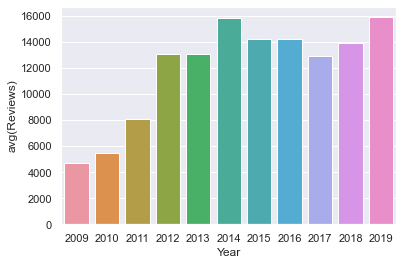

In [63]:
df_reviews = df.groupBy("Year").agg({"Reviews": "avg"}).sort("Year", ascending=True).toPandas()

sns.set(style="darkgrid")

# sns.histplot(data=df_reviews, x="Year", y="avg(Reviews)", bins=11)
sns.barplot(x="Year", y="avg(Reviews)", data=df_reviews)

<AxesSubplot:xlabel='Genre', ylabel='count(Genre)'>

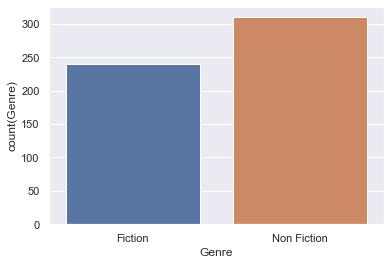

In [64]:
df_genres = df.groupBy("Genre").agg({"Genre": "count"}).toPandas()

sns.set(style="darkgrid")

# sns.histplot(data=df_reviews, x="Year", y="avg(Reviews)", bins=11)
sns.barplot(x="Genre", y="count(Genre)", data=df_genres)